In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import awkward
import itertools
import time, sys
import matplotlib.colors
from IPython.display import clear_output
import scipy.optimize as optimization
import multiprocessing as mp
import functools
import tqdm
import scipy 

def update_progress(i, nfiles): #progress bar, just for show
    progress = i / nfiles
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "N Files to process = {0} \nProgress: [{1}] {2:.1f}%".format(nfiles, "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [2]:
#get ER and NR band files:
erBandFile = [line.rstrip() for line in open("/global/cfs/cdirs/lz/physics/NEST_Bands/SR1/20220511/Calibration/CH3T_SR1_logS2_gaussian_band.txt")]
nrBandFile = [line.rstrip() for line in open("/global/cfs/cdirs/lz/physics/NEST_Bands/SR1/20220511/Calibration/DD_SR1_logS2_gaussian_band.txt")]#global/cfs/cdirs/lz/users/grischbi/CommissioningBands/v5/DD_SR1_NEST_546_logS2_gaussian_band.txt
gammaBandFile = [line.rstrip() for line in open("/global/cfs/cdirs/lz/users/grischbi/NESTv2.0/v2.0.1/build/gammaBand_MDC3.dat")]

xER, yER, yHiER, yLoER = [], [], [], []
xNR, yNR, yHiNR, yLoNR = [], [], [], []
xGR, yGR, yHiGR, yLoGR = [], [], [], []
    
for i in range(1, len(erBandFile)-1):
    templist = erBandFile[i].split()
    xER.append(float(templist[0]))
    yER.append(float(templist[1]))
    yHiER.append(float(templist[1]) + float(templist[2]))
    yLoER.append(float(templist[1]) - float(templist[2]))


for i in range(1, len(gammaBandFile)-1):
    templist = gammaBandFile[i].split()
    xGR.append(float(templist[0]))
    yGR.append(float(templist[2]))
    yHiGR.append(float(templist[2]) + 1.282*float(templist[4]))
    yLoGR.append(float(templist[2]) - 1.282*float(templist[4]))
    
for i in range(1, len(nrBandFile)-1):
    templist = nrBandFile[i].split()
    xNR.append(float(templist[0]))
    yNR.append(float(templist[1]))
    yHiNR.append(float(templist[1]) + float(templist[2]))
    yLoNR.append(float(templist[1]) - float(templist[2]))
    #print(xNR[i-1], yNR[i-1])
    
def plotER(label):
    if label == True:
        plt.plot(xER, yER, 'r', lw = 2.5, label = 'ER Band')
    else:
        plt.plot(xER, yER, 'r', lw = 2.5)
    plt.plot(xER, yHiER, 'r--', lw = 2.5)
    plt.plot(xER, yLoER, 'r--', lw = 2.5)

def plotGamma(label):
    if label == True:
        plt.plot(xGR, yGR, 'g', lw = 2.5, label = r'$\gamma$ Band')
    else:
        plt.plot(xGR, yGR, 'g', lw = 2.5)
    plt.plot(xGR, yHiGR, 'g--', lw = 2.5)
    plt.plot(xGR, yLoGR, 'g--', lw = 2.5)

def plotNR(label):
    if label == True:
        plt.plot(xNR, yNR, 'b', lw = 2.5, label = 'NR Band')
    else:
        plt.plot(xNR, yNR, 'b', lw = 2.5)
    plt.plot(xNR, yHiNR, 'b--', lw = 2.5)
    plt.plot(xNR, yLoNR, 'b--', lw = 2.5)
    
print("Done!")

Done!


In [3]:
#base_path1 = '/global/cfs/cdirs/lz/data/reconstructed/commissioning/LZAP-5.3.8_PROD-2/202111/'  #Rnpath
#runs1 = [6014,6015] #Rn runs
#base_path2 = '/global/cfs/cdirs/lz/data/reconstructed/commissioning/LZAP-5.3.7_PROD-0/202111/'# OldKr path
#runs2 = [6054,6055,6056,6057,6058,6059] #Old Kr runs
#base_path3 = '/global/cfs/cdirs/lz/data/reconstructed/commissioning/LZAP-5.3.8_PROD-2/202111/' #AmLi path
#runs3 = [6134,6135,6136,6137,6138,6139,6140] # AmLi runs
#base_path4 = '/global/cfs/cdirs/lz/data/reconstructed/SR1/LZAP-5.4.1_PROD-1/202201/'# New Kr path
#runs4 = [7090,7091,7092,7093,7094] #New Kr runs
base_path5 = '/global/cfs/cdirs/lz/data/reconstructed/SR1/LZAP-5.4.6_PROD-2/202112/' #xmas ws bkg
runs5 = range(6771,6790) #xmas WSbkg
base_path6 = '/global/cfs/cdirs/lz/data/reconstructed/SR1/LZAP-5.4.6_PROD-2/202201/' #xmas ws bkg
runs6 = range(6860,6890) #xmas WSbkg
files = []
#for run in runs1:
#    files.extend(glob.glob(base_path1 + '*{0:06d}/rq/*.root'.format(run)))
#for run in runs2:
#    files.extend(glob.glob(base_path2 + '*{0:06d}/rq/*.root'.format(run)))
#for run in runs3:
#    files.extend(glob.glob(base_path3 + '*{0:06d}/rq/*.root'.format(run)))
#for run in runs4:
#    files.extend(glob.glob(base_path4 + '*{0:06d}/rq/*.root'.format(run)))
for run in runs5:
    files.extend(glob.glob(base_path5 + '*{0:06d}/rq/*.root'.format(run)))
for run in runs6:
    files.extend(glob.glob(base_path6 + '*{0:06d}/rq/*.root'.format(run)))
print(len(files))

1140


In [ ]:
#If using the DD dataset:
files = glob.glob('/global/cfs/projectdirs/lz/users/sally/UCSB/SR1/NRDataset/*.root*')

In [ ]:
#If using tritium
files545 = []
files = []

runs545 = '/global/cfs/cdirs/lz/users/grischbi/SR1_Calibration/tritium_April_545.list'
runs546 = '/global/cfs/cdirs/lz/users/grischbi/SR1_Calibration/tritium_April_546.list'

with open(runs545) as r545:
    lines545 = r545.readlines()
    lines545 = [line.rstrip() for line in lines545]

with open(runs546) as r546:
    lines546 = r546.readlines()
    lines546 = [line.rstrip() for line in lines546]
    
for file in lines545:
    files545.extend(glob.glob(file))
print(len(files545))
for file in lines546:
    files.extend(glob.glob(file))
print(len(files))

In [ ]:
def pulsestatsS1(thefile): #main function where we get the needed things from the RQs
    events = uproot.open(thefile)['Events']
    scatters = uproot.open(thefile)['Scatters']
    eventsPID = events.array('pulsesTPC.pulseID')
    PA = events.array('pulsesTPC.pulseArea_phd')
    PS = events.array('pulsesTPC.pulseStartTime_ns')/1000
    S1prob = events.array('pulsesTPC.s1Probability')
    S2prom = scatters.array('ss.s2PulseID')
    PH = events.array('pulsesTPC.peakAmp')
    a = events.array('pulsesTPC.areaFractionTime95_ns')
    b = events.array('pulsesTPC.areaFractionTime5_ns')
    runID = events.array('eventHeader.runID')
    eventID = events.array('eventHeader.eventID')
    nSS = scatters.array('ss.nSingleScatters')
    DS1 = scatters.array('ss.isDoubleS1')
    x = scatters.array('ss.x_cm')
    y = scatters.array('ss.y_cm')
    r = np.sqrt(x**2 + y**2)
    drift = scatters.array('ss.driftTime_ns')/ 1000

    PW = a - b

    isSS = nSS == 1

    PASS = PA[isSS]
    PWSS = PW[isSS]
    PHSS = PH[isSS]
    PSSS = PS[isSS]
    S1prob = S1prob[isSS]
    S2prom = S2prom[isSS]
    runID = runID[isSS]
    eventID = eventID[isSS]
    DS1 = DS1[isSS]
    r = r[isSS]
    drift = drift[isSS]

    isnotDS1 = DS1 == 0
    
    PASS = PASS[isnotDS1]
    PWSS = PWSS[isnotDS1]
    PHSS = PHSS[isnotDS1]
    PSSS = PSSS[isnotDS1]
    S1prob = S1prob[isnotDS1]
    S2prom = S2prom[isnotDS1]
    runID = runID[isnotDS1]
    eventID = eventID[isnotDS1]
    r = r[isnotDS1]
    drift = drift[isnotDS1]
    
    isS1 = S1prob > 0 #assign a boolean true for a value with a S1 to make a mask for S1s
    PAS1 = PASS[isS1] # grab pulse areas for S1s
    PWS1 = PWSS[isS1]
    PHS1 = PHSS[isS1]
    PSS1 = PSSS[isS1]

    PSS2 = [] #rgab the S2 start time 
    PAS2 = [] 

    for i,j in zip(PSSS,S2prom):
        PSS2.append(i[j])

    for i,j in zip(PASS,S2prom):
        PAS2.append(i[j])

    PAS2 = np.array(PAS2)
    PSS2 = np.array(PSS2)

    morethan1_S1 = PAS1.count() > 1 #make a mask that makes sure there are multple S1s in an event

    PA_MultiS1 = PAS1[morethan1_S1] #get the relevant areas, width, and heights
    PW_MultiS1 = PWS1[morethan1_S1]
    PH_MultiS1 = PHS1[morethan1_S1] # Only have events with more than 1 s1 now
    PSS2 = PSS2[morethan1_S1]
    PAS2 = PAS2[morethan1_S1]
    PSS1 = PSS1[morethan1_S1]
    runIDS1 = runID[morethan1_S1]
    eventIDS1 = eventID[morethan1_S1]   
    r = r[morethan1_S1]
    drift = drift[morethan1_S1]

    DT = np.subtract(PSS2,PSS1) # get events that have at least one S1 within drift time

    upperz = DT < 936.5 
    lowerz = DT > 86
    FIDZ_ID = np.logical_and(upperz,lowerz)

    DTcut = []
    for i in FIDZ_ID:
        if any(i):
            DTcut.append(True)
        else:
            (DTcut.append(False))

    PA_DT = PA_MultiS1[DTcut] #get the relevant areas, width, and heights
    PW_DT = PW_MultiS1[DTcut]
    PH_DT = PH_MultiS1[DTcut] # Only have events with more than 1 s1 now
    runIDDT = runIDS1[DTcut]
    eventIDDT = eventIDS1[DTcut] 
    PAS2 = PAS2[DTcut]
    PSS1 = PSS1[DTcut]
    PSS2 = PSS2[DTcut]
    r = r[DTcut]
    drift = drift[DTcut]


    PAmaxS1 = PA_DT.max()  #find the max area in each event

    lowE = PAmaxS1 < 1000

    PA_lowE = PA_DT[lowE] #get the relevant areas, width, and heights
    PW_lowE = PW_DT[lowE]
    PH_lowE = PH_DT[lowE] # Only have events with more than 1 s1 now
    runIDlowE = runIDDT[lowE]
    eventIDlowE = eventIDDT[lowE] 
    PAS2 = PAS2[lowE]
    PSS1 = PSS1[lowE]
    PSS2 = PSS2[lowE]
    r = r[lowE]
    drift = drift[lowE]

    S1smalllow = PA_lowE.argsort() == 1 #mask to find the 2nd largest S1 in an event
    S1biglow = PA_lowE.argsort() == 0

    PSsmall = PSS1[S1smalllow]
    PSbig = PSS1[S1biglow]


    smalltime = PSsmall < PSS2 #we want to make sure that the largest and 2nd largest are before the S2
    bigtime = PSbig < PSS2
    time_ID = np.logical_and(smalltime,bigtime)
    time_ID = list(itertools.chain.from_iterable(time_ID))

    PA_time = PA_lowE[time_ID] #get the relevant areas, width, and heights
    PW_time = PW_lowE[time_ID]
    PH_time = PH_lowE[time_ID] # Only have events with more than 1 s1 now
    runIDtime = runIDlowE[time_ID]
    eventIDtime = eventIDlowE[time_ID] 
    PAS2 = PAS2[time_ID]
    PSS1 = PSS1[time_ID]
    PSS2 = PSS2[time_ID]
    r = r[time_ID]
    drift = drift[time_ID]

    PAmaxS1 = PA_time.max()  #find the max area in each event

    S1small = PA_time.argsort() == 1    
    S1big = PA_time.argsort() == 0
    PAsmallS1 = PA_time[S1small] #2nd largest area
    PHsmallS1 = PH_time[S1small] #2nd largest height
    PWsmallS1 = PW_time[S1small] #2nd largest width
    PSsmall = PSS1[S1small]
    PSbig = PSS1[S1big]
    
    S1ratio = np.log10(PAsmallS1 / PAmaxS1) #calculate desired ratios to plot
    S1_h2w_ratio = np.log10(PHsmallS1 / PWsmallS1)


    return S1ratio , S1_h2w_ratio , PAmaxS1,PAsmallS1,runIDtime,eventIDtime,PAS2,PSsmall,PSbig,DS1,r,drift

In [ ]:
S1xaxis = []
S1yaxis = []
S1max = []
s1small = []
runIDS1 = []
eventIDS1 = []
S2max = []
PSsmall = []
PSbig = []
DS1 = []

In [ ]:
nfiles = len(files)
#for i, file in enumerate(files):
with mp.Pool(16) as pool:
    results = list(tqdm.tqdm(pool.imap(functools.partial(pulsestatsS1),files)))        


In [ ]:
for i in results:
    S1xaxis.append(i[0])
    S1yaxis.append(i[1])
    S1max.append(i[2])
    s1small.append(i[3])
    runIDS1.append(i[4])
    eventIDS1.append(i[5])
    S2max.append(i[6])
    PSsmall.append(i[7])
    PSbig.append(i[8])
    DS1.append(i[9])

In [ ]:
S1max = list(itertools.chain.from_iterable(S1max))
S2max = list(itertools.chain.from_iterable(S2max))
s1small = list(itertools.chain.from_iterable(s1small))
s1small = list(itertools.chain.from_iterable(s1small))
runIDS1 = list(itertools.chain.from_iterable(runIDS1))
eventIDS1 = list(itertools.chain.from_iterable(eventIDS1))
S1xaxis = list(itertools.chain.from_iterable(S1xaxis))
S1yaxis = list(itertools.chain.from_iterable(S1yaxis))
S1xaxis = list(itertools.chain.from_iterable(S1xaxis))
S1yaxis = list(itertools.chain.from_iterable(S1yaxis))
PSsmall = list(itertools.chain.from_iterable(PSsmall))
PSsmall = list(itertools.chain.from_iterable(PSsmall))
PSbig = list(itertools.chain.from_iterable(PSbig))
PSbig = list(itertools.chain.from_iterable(PSbig))
DS1 = list(itertools.chain.from_iterable(DS1))
#PAss = list(itertools.chain.from_iterable(PAss))

In [ ]:
#Number of SS in the dataset
print(len(DS1))

In [ ]:
DS1[0:10]

Make the basic IF plots for the S1s

In [ ]:
logs1 = np.log10(S1max) #take logs of areas
logs2 = np.log10(S2max)

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.hist2d(S1max, logs2, bins=(1000, 1000), cmin=1,norm=matplotlib.colors.LogNorm())#norm=matplotlib.colors.LogNorm()
plt.colorbar()
#plt.scatter(cutS1, cutlogs2,marker = 'x',color = 'r',label = 'Cut')
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_title('WS Runs 6771 - 6790 & 6860-6890 S1 vs log(S2)')
ax.set_xlabel('S1 area')
ax.set_ylabel('log(S2) area')
plotER(True)
plotNR(True)
#plt.xticks(np.arange(min(logs1), max(logs1), 0.4))
plt.legend(prop={'size': 20})
plt.show()

In [ ]:
expS1xaxis = np.power(10,S1xaxis)
expS1yaxis = np.power(10,S1yaxis)

In [ ]:
xspace = np.linspace(1e-5,10,5000)
s1y2 = 5e-4*xspace**(-0.5)

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.hist2d(expS1xaxis, expS1yaxis, bins=np.logspace(start=np.log10(1e-5), stop=np.log10(1), num=500),range = [[1e-5, 1], [1e-7, 10e-1]],norm=matplotlib.colors.LogNorm())
plt.colorbar()
#plt.plot(xspace, function, label="Fitted Curve")
#plt.plot(xdata,ydata)
plt.xlim([1e-3, 1])
plt.plot(xspace,s1y2,'r-')
#plt.axhline(y=8.4e-4, color='r', linestyle='-')
plt.ylim([1e-5, 5e-2])
#plt.yscale("log")
#plt.xscale("log")

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('2nd S1 Area over Largest S1 area ')
ax.set_ylabel('Height/Width of 2nd largest S1')
ax.set_title('WS Runs 6771 - 6790 & 6860-6890 S1 Prominent Selection Space')

plt.show()

Lets try to make some extra plots

In [ ]:
from scipy.optimize import curve_fit
from scipy.stats import skewnorm
params = skewnorm.fit(expS1yaxis, 9, loc=1.3e-4, scale=2e-4)
fitspace = np.logspace(np.log10(1e-4),np.log10(1e-3), 100)

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
n, bins, patches = plt.hist(expS1yaxis, bins=np.logspace(np.log10(0.00001),np.log10(1.0), 1000)) #facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=1)
#n = n.astype('int')
#for i in range(len(patches)):
#    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))
plt.plot(fitspace, skewnorm.pdf(fitspace,8.85, loc=1.3e-4, scale=0.0002346952382026053), label='approximated skewnorm')
ax.set_yscale('log')
ax.set_xscale('log')
plt.title('H/W of 1000phd < S2s < 2000phd & 10% Largest S2 Area') 
plt.xlabel('Height/Width') 
plt.ylabel('Counts')
plt.grid(True)
plt.show()

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.hist2d(S1max, expS1yaxis, bins=np.logspace(start=np.log10(1e-5), stop=np.log10(100), num=500),range = [[0.1, 100], [1e-7, 10e-1]],norm=matplotlib.colors.LogNorm())
plt.colorbar()
#plt.plot(xspace, function, label="Fitted Curve")
#plt.plot(xdata,ydata)
plt.xlim([1, 100])
plt.plot(xspace,s1y2,'r-')
#plt.axhline(y=8.4e-4, color='r', linestyle='-')
plt.ylim([1e-5, 5e-2])
#plt.yscale("log")
#plt.xscale("log")

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('S1 area ')
ax.set_ylabel('Height/Width of 2nd largest S1')
ax.set_title('WS Runs 6771 - 6790 & 6860-6890 S1 Prominent Selection Space')

plt.show()

In [ ]:
from scipy.stats import binned_statistic
bin_means = scipy.stats.binned_statistic(S1max, expS1yaxis, statistic='mean', bins=20, range=(1, 1000))

In [ ]:
blah = bin_means[1]
blah = np.delete(blah,[0])

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.scatter(blah,np.log10(bin_means[0]),color = 'midnightblue',label = 'All')
ax.set_title('WS Runs 6771 - 6790 Largest S1 vs 2nd Largest S1')
ax.set_xlabel('Largest S1 area ')
ax.set_ylabel('h2w')
plt.legend(prop={'size': 20})

4sigma h/w value = 8.4e-4

Develop the IF Prom based cut

In [ ]:
IDs = []
saved = []
count = 0
for i,(j,k) in enumerate(zip(expS1yaxis,expS1xaxis)):
    if j > 5e-4*k**(-0.5):
        count +=1
        print(runIDS1[i], eventIDS1[i])
        IDs.append(True)
        saved.append(False)
        #if count < 50:
         #   print(runIDS1[i], eventIDS1[i])
    else:
        IDs.append(False)
        saved.append(True)

In [ ]:
CutS1 = np.array(S1max)
CutS2 = np.array(S2max)
CutS1small = np.array(s1small)
Cutrun = np.array(runIDS1)
Cutevent = np.array(eventIDS1)

In [ ]:
cutS1 = list(CutS1[IDs])
cutS2 = list(CutS2[IDs])
cutS1small = list(CutS1small[IDs])

savedS1 = list(CutS1[saved])
savedS2 = list(CutS2[saved])
savedS1small = list(CutS1small[saved])
savedrunID = list(Cutrun[saved])
savedeventID = list(Cutevent[saved])


In [ ]:
cutlogs2 = np.log10(cutS2)

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.hist2d(cutS1, cutlogs2, bins=(1000, 1000), cmin=1,norm=matplotlib.colors.LogNorm())#norm=matplotlib.colors.LogNorm()
plt.colorbar()
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_title('Kr S1 vs S2')
ax.set_xlabel('S1 area ')
ax.set_ylabel('S2 area')
#plt.xticks(np.arange(min(logs1), max(logs1), 0.4))
plt.show()

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.scatter(cutS1, cutlogs2,marker = 'x',color = 'k')
ax.set_title('WS Runs 6771 - 6790 S1 vs S2 - Cut')
ax.set_xlabel('S1 area ')
ax.set_ylabel('log(S2) area')
#plt.xticks(np.arange(min(logs1), max(logs1), 0.4))
plt.show()

Some are plots based on prom cut

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.hist(s1small,color='royalblue',bins = 20)
plt.hist(S1max,color='firebrick',bins = 20,alpha=0.5)
ax.set_yscale('log')
plt.show()

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.hist(cutS1small,color='royalblue',bins = 20)
plt.hist(cutS1,color='firebrick',bins = 20,alpha=0.5)
ax.set_yscale('log')
plt.show()

In [ ]:
testspace = np.linspace(0,100,500)
#cutfunc = 2*(np.log(testspace - 4))+ 3
cutfunc = 0.1*testspace+5

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.scatter(S1max,s1small,color = 'midnightblue',label = 'All')
plt.scatter(cutS1,cutS1small,marker = 'x',color = 'r',label = 'Cut')
plt.plot(testspace,cutfunc,'r-')
ax.set_title('WS Runs 6771 - 6790 Largest S1 vs 2nd Largest S1')
ax.set_xlabel('Largest S1 area ')
ax.set_ylabel('2nd Largest S1 area')
plt.legend(prop={'size': 20})

In [ ]:
for i,(j,k) in enumerate(zip(s1small,S1max)):
    if j > 0.1*k + 5 and k > 20:
        print(runIDS1[i], eventIDS1[i])

In [ ]:
test = [x/y for x,y in zip(s1small,S1max)]
test2 = [x/y for x,y in zip(cutS1small,cutS1)]

In [ ]:
testcut = 10*np.exp(-0.27*testspace)+0.18
testcut2 = 7*np.exp(-0.23*testspace)+0.13
testcut3 = 10*np.exp(-0.35*testspace)+0.18

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.hist2d(S1max, test,bins=500,cmin=1,norm=matplotlib.colors.LogNorm()) #facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=1)
#plt.scatter(cutS1,test2,marker = 'x',color = 'r',label = 'Cut')
plt.colorbar()
plt.plot(testspace,testcut,'r-')
plt.plot(testspace,testcut2,'b-')
#plt.plot(testspace,testcut3,'k-')
#n = n.astype('int')
#for i in range(len(patches)):
#    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))
#ax.set_yscale('log')
#ax.set_xscale('log')
#plt.ylim([0,100])
plt.title('') 
plt.xlim(0,100)
plt.ylabel('2nd Largest S1/Largest S1') 
plt.xlabel('Largest S1 Area')
ax.set_title('WS Runs 6771 - 6790 & 6860-6890 S1 Cut Space')
plt.grid(True)
plt.show()

In [ ]:
testspace2 = np.linspace(100,1000,500)
s1lincut = testspace2

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.hist2d(S1max, test,bins=500,cmin=1,norm=matplotlib.colors.LogNorm()) #facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=1)
#plt.scatter(cutS1,test2,marker = 'x',color = 'r',label = 'Cut')
plt.colorbar()
#plt.axhline(y=0.052, color='g', linestyle='-')
plt.title('') 
plt.xlim(100,1000)
plt.ylabel('2nd Largest S1/Largest S1') 
plt.xlabel('Largest S1 Area')
ax.set_title('WS Runs 6771 - 6790 & 6860-6890 S1 Cut Space')
plt.grid(True)
plt.show()

In [ ]:
#ratiocut = []
for i,(j,k) in enumerate(zip(S1max,test)):
    if j > 100 and j < 300 and k > 0.05:
    #if k > 0.4 and j < 4:
        print(runIDS1[i], eventIDS1[i])
        #print(s1small[i],S1max[i])
        #ratiocut.append(True)
        #if count < 50:

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.scatter(S1max,test,color = 'midnightblue',label = 'All')
plt.scatter(cutS1,test2,marker = 'x',color = 'r',label = 'Cut')
plt.plot(testspace2,s1lincut,'r-')
plt.plot(testspace,testcut2,'b-')
plt.plot(testspace,testcut3,'k-')
plt.axhline(y=0.2, color='g', linestyle='-')
plt.axhline(y=0.1, color='g', linestyle='-')
plt.axvline(x=15, color='g', linestyle='-')
plt.ylim([0, 1])
ax.set_title('WS Runs 6771 - 6790 Largest S1 vs 2nd Largest S1')
ax.set_xlabel('Largest S1 area ')
ax.set_ylabel('2nd Largest S1 area')
plt.legend(prop={'size': 20})

In [ ]:
ratiocut = []
for i,(j,k) in enumerate(zip(S1max,test)):
    if k > 10*np.exp(-0.27*j)+0.18 and k < 0.95 and j < 100:
    #if j > 40 and k > 0.1 and k < 0.2:
        print(runIDS1[i], eventIDS1[i])
        #print(s1small[i],S1max[i])
        ratiocut.append(True)
        #if count < 50:
    else:
        ratiocut.append(False)

In [ ]:
CutS1smalltime = np.array(PSsmall)
CutS1time = np.array(PSbig)
CutS1max = np.array(S1max)
CutS2max = np.array(S2max)
rcutS1 = list(CutS1time[ratiocut])
rcutS1small = list(CutS1smalltime[ratiocut])
rcutrunID = list(Cutrun[ratiocut])
rcuteventID = list(Cutevent[ratiocut])
rcutS1max = list(CutS1max[ratiocut])
rcutS2max = list(CutS2max[ratiocut])

In [ ]:
S1sep = np.abs(np.subtract(PSbig,PSsmall))
cutS1sep = np.abs(np.subtract(rcutS1,rcutS1small))

In [ ]:
smalltime = S1sep < 4
smallS1sep = S1sep[smalltime]

In [ ]:
cutsmalltime = cutS1sep < 10
smallcutS1sep = cutS1sep[cutsmalltime]

In [ ]:
print(len(eventIDS1))
print(len(rcuteventID))

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.hist(smallS1sep,color='royalblue',bins = 200)
plt.xlim(0,4)
plt.axvline(x=3.83, color='r', linestyle='--')
ax.set_yscale('log')
ax.set_xlabel('S1 Seperation Time [us]')
ax.set_title('WS Runs 6771 - 6790 & 6860-6890 S1 Seperation Time')
plt.show()

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.hist(smallcutS1sep,color='firebrick',bins = 50)
plt.axvline(x=3.83, color='r', linestyle='--')
ax.set_yscale('log')
ax.set_xlabel('S1 Seperation Time [us]')
ax.set_title('WS Runs 6771 - 6790 & 6860-6890 S1 Seperation Time - Cut')
plt.show()

In [ ]:
for i,j in enumerate(cutS1sep):
    if j < 0.75:
        print(rcutrunID[i], rcuteventID[i])

In [ ]:
CutS1max = np.array(S1max)
CutS1test = np.array(test)
CutS2max = np.array(S2max)
fullcuttime = S1sep > 0.75
fullS1maxcut = list(CutS1max[fullcuttime])
fullS1testcut = list(CutS1test[fullcuttime])
fullS2testcut = list(CutS2max[fullcuttime])

In [ ]:
fullcuttime

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.hist2d(fullS1maxcut, fullS1testcut,bins=100,cmin=1,norm=matplotlib.colors.LogNorm()) #facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=1)
#plt.scatter(cutS1,test2,marker = 'x',color = 'r',label = 'Cut')
plt.colorbar()
plt.plot(testspace,testcut,'r-')
#plt.plot(testspace,testcut2,'b-')
#plt.plot(testspace,testcut3,'k-')
#n = n.astype('int')
#for i in range(len(patches)):
#    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))
#ax.set_yscale('log')
#ax.set_xscale('log')
#plt.ylim([0,100])
plt.title('') 
plt.ylabel('2nd Largest S1/Largest S1') 
plt.xlabel('Largest S1 Area')
ax.set_title('DD Neutron S1 Cut Space')
plt.grid(True)
plt.show()

In [ ]:
print(len(fullS1maxcut))

In [ ]:
finalcount = []
for i,(j,k) in enumerate(zip(fullS1maxcut,fullS1testcut)):
    if k > 10*np.exp(-0.27*j)+0.18 and j < 100:
        finalcount.append(True)
    else:
        finalcount.append(False)

In [ ]:
print(len(finalcount))

In [ ]:
eftcount = []
for i,(j,k) in enumerate(zip(fullS1maxcut,fullS1testcut)):
    if k > 0.05 and j > 100:
        eftcount.append(True)
    else:
        eftcount.append(False)

Make the plots for the cut efficiency 

In [ ]:
CutfullS1maxcut = np.array(fullS1maxcut)
CutfullS2testcut = np.array(fullS2testcut)
finalcutS1s = list(CutfullS1maxcut[finalcount])
finalcutS2s = list(CutfullS2testcut[finalcount])

In [ ]:
CutfullS1maxcut = np.array(fullS1maxcut)
CutfullS2testcut = np.array(fullS2testcut)
eftcutS1s = list(CutfullS1maxcut[eftcount])
eftcutS2s = list(CutfullS2testcut[eftcount])

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.hist2d(finalcutS1s, np.log10(finalcutS2s), bins=(200, 200),range =  [[0,1000], [2,5]], cmin=1,norm=matplotlib.colors.LogNorm())#norm=matplotlib.colors.LogNorm()
plt.hist2d(eftcutS1s, np.log10(eftcutS2s), bins=(200, 200),range =  [[0,1000], [2,5]], cmin=1,norm=matplotlib.colors.LogNorm())#norm=matplotlib.colors.LogNorm()
plt.colorbar()
#ax.set_yscale('log')
#ax.set_xscale('log')
#plt.plot(xspace, function, label="Fitted Curve")
#plt.plot(xdata,ydata)
ax.set_title('WS Runs 6771 - 6790 & 6860-6890 S1 Cut')
ax.set_xlabel('S1 area ')
ax.set_ylabel('Log(S2) area')
plotER(True)
plotNR(True)
#plt.xticks(np.arange(min(logs1), max(logs1), 0.4))
plt.show()

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
n, bins, patches = plt.hist(finalcutS1s,color='royalblue',bins = 40)
n1, bins1, patches1 = plt.hist(CutfullS1maxcut,color='firebrick',bins = 40,alpha=0.5)
ax.set_yscale('log')
plt.show()

In [ ]:
s1eff = n/n1

In [ ]:
newbins = bins
newbins = np.delete(newbins,[0])

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.scatter(newbins,s1eff,color = 'midnightblue',label = 'All')
plt.show()

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
n2, bins2, patches2 = plt.hist(np.log10(finalcutS2s),color='royalblue',bins = 40)
n3, bins3, patches3 = plt.hist(np.log10(CutfullS2testcut),color='firebrick',bins = 40,alpha=0.5)
ax.set_yscale('log')
plt.show()

In [ ]:
s2eff = n2/n3

In [ ]:
newbins1 = bins
newbins1 = np.delete(newbins1,[0])

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.scatter(newbins1,s2eff,color = 'midnightblue',label = 'All')
plt.show()

In [ ]:


testfile  = "/global/cfs/cdirs/lz/data/reconstructed/SR1/LZAP-5.4.5_PROD-0/202201/lz_202201231137_007161/rq/lz_007161_000068_rq.root"
events = uproot.open(testfile)['Events']
scatters = uproot.open(testfile)['Scatters']
eventsPID = events.array('pulsesTPC.pulseID')
S1prob = events.array('pulsesTPC.s1Probability')
S2prob = events.array('pulsesTPC.s2Probability')
PA = events.array('pulsesTPC.pulseArea_phd')
PH = events.array('pulsesTPC.peakAmp')
a = events.array('pulsesTPC.areaFractionTime95_ns')
b = events.array('pulsesTPC.areaFractionTime5_ns')
runID = events.array('eventHeader.runID')
eventID = events.array('eventHeader.eventID')
PW = a - b

EID = eventID == 75497


PA = PA[EID]
PW = PW[EID]
PH = PH[EID]
S1prob = S1prob[EID]
S2prob = S2prob[EID]
eventsPID = eventsPID[EID]

isS1 = S1prob > 0 #assign a boolean true for a value with a S1 to make a mask for S1s
PAS1 = PA[isS1] # grab pulse areas for S1s
PWS1 = PW[isS1]
PHS1 = PH[isS1]

isS2 = S2prob > 0 #assign a boolean true for a value with a S1 to make a mask for S1s
PAS2 = PA[isS2] # grab pulse areas for S1s
PWS2 = PW[isS2]
PHS2 = PH[isS2]
eventsPID = eventsPID[isS1]

morethan1_S1 = PAS1.count() > 1
PA_MultiS1 = PAS1[morethan1_S1]
PW_MultiS1 = PWS1[morethan1_S1]
PH_MultiS1 = PHS1[morethan1_S1] # Only have events with more than 1 s1 now
eventsPID = eventsPID[morethan1_S1]

isPID = eventsPID == 28
PAmaxS1 = PA_MultiS1.max()
S1small = PA_MultiS1.argsort() == 1
PAsmallS1 = PA_MultiS1[isPID]
PHsmallS1 = PH_MultiS1[isPID]
PWsmallS1 = PW_MultiS1[isPID]
eventsPID = eventsPID[S1small]

S1ratio = np.log10(PAsmallS1 / PAmaxS1)
S1_h2w_ratio = np.log10(PHsmallS1 / PWsmallS1)


In [ ]:
np.power(10,S1_h2w_ratio)

In [ ]:
np.power(10,S1ratio)

In [ ]:
eventsPID

In [ ]:
/global/cfs/projectdirs/lz/users/sally/UCSB/SR1/NRDataset/PA

In [ ]:
def pulsestats(thefile): #main function where we get the needed things from the RQs
    events = uproot.open(thefile)['Events']
    scatters = uproot.open(thefile)['Scatters']
    eventsPID = events.array('pulsesTPC.pulseID')
    PA = events.array('pulsesTPC.pulseArea_phd')
    PS = events.array('pulsesTPC.pulseStartTime_ns')/1000
    S2prob = events.array('pulsesTPC.s2Probability')
    S1prom = scatters.array('ss.s1PulseID')
    PH = events.array('pulsesTPC.peakAmp')
    a = events.array('pulsesTPC.areaFractionTime95_ns')
    b = events.array('pulsesTPC.areaFractionTime5_ns')
    runID = events.array('eventHeader.runID')
    eventID = events.array('eventHeader.eventID')
    nSS = scatters.array('ss.nSingleScatters')
    DS1 = scatters.array('ss.isDoubleS1')
    x = scatters.array('ss.x_cm')
    y = scatters.array('ss.y_cm')
    r = np.sqrt(x**2 + y**2)
    drift = scatters.array('ss.driftTime_ns')/ 1000

    PW = a - b

    isSS = nSS == 1

    PASS = PA[isSS]
    PWSS = PW[isSS]
    PHSS = PH[isSS]
    PSSS = PS[isSS]
    S2prob = S2prob[isSS]
    S1prom = S1prom[isSS]
    runID = runID[isSS]
    eventID = eventID[isSS]

    
    isS2 = S2prob > 0 #assign a boolean true for a value with a S1 to make a mask for S1s
    PAS2 = PASS[isS2] # grab pulse areas for S1s
    PWS2 = PWSS[isS2]
    PHS2 = PHSS[isS2]
    PSS2 = PSSS[isS2]

    PSS1 = [] #rgab the S2 start time 
    PAS1 = [] 

    for i,j in zip(PSSS,S1prom):
        PSS1.append(i[j])

    for i,j in zip(PASS,S1prom):
        PAS1.append(i[j])

    PAS1 = np.array(PAS1)
    PSS1 = np.array(PSS1)

    morethan1_S2 = PAS2.count() > 1 #make a mask that makes sure there are multple S1s in an event

    PA_MultiS2 = PAS2[morethan1_S2] #get the relevant areas, width, and heights
    PW_MultiS2 = PWS2[morethan1_S2]
    PH_MultiS2 = PHS2[morethan1_S2] # Only have events with more than 1 s1 now
    PSS1 = PSS1[morethan1_S2]
    PAS1 = PAS1[morethan1_S2]
    PSS2 = PSS2[morethan1_S2]
    runIDS2 = runID[morethan1_S2]
    eventIDS2 = eventID[morethan1_S2]   


    PAmaxS2 = PA_MultiS2.max()  #find the max area in each event

    s2max = PAmaxS2 < 1e7
    s2min = PAmaxS2 > 600
    lowE = np.logical_and(s2max,s2min)

    """DTcut = []
    for i in FIDZ_ID:
        if any(i):
            DTcut.append(True)
        else:
            (DTcut.append(False))"""


    PA_lowE = PA_MultiS2[lowE] #get the relevant areas, width, and heights
    PW_lowE = PW_MultiS2[lowE]
    PH_lowE = PH_MultiS2[lowE] # Only have events with more than 1 s1 now
    runIDlowE = runIDS2[lowE]
    eventIDlowE = eventIDS2[lowE] 
    PAS1 = PAS1[lowE]
    PSS2 = PSS2[lowE]
    PSS1 = PSS1[lowE]

    S2smalllow = PA_lowE.argsort() == 1 #mask to find the 2nd largest S1 in an event
    S2biglow = PA_lowE.argsort() == 0

    PSsmall = PSS2[S2smalllow]
    PSbig = PSS2[S2biglow]


    time_ID = PSsmall > PSS1 #we want to make sure that the largest and 2nd largest are before the S2
#    time_ID = np.logical_and(smalltime,bigtime)
    time_ID = list(itertools.chain.from_iterable(time_ID))

    PA_time = PA_lowE[time_ID] #get the relevant areas, width, and heights
    PW_time = PW_lowE[time_ID]
    PH_time = PH_lowE[time_ID] # Only have events with more than 1 s1 now
    runIDtime = runIDlowE[time_ID]
    eventIDtime = eventIDlowE[time_ID] 
    PAS1 = PAS1[time_ID]
    PSS2 = PSS2[time_ID]
    PSS1 = PSS1[time_ID]

    PAmaxS2 = PA_time.max()  #find the max area in each event

    S2small = PA_time.argsort() == 1    
    S2big = PA_time.argsort() == 0
    PAsmallS2 = PA_time[S2small] #2nd largest area
    PHsmallS2 = PH_time[S2small] #2nd largest height
    PWsmallS2 = PW_time[S2small] #2nd largest width
    PSsmall = PSS2[S2small]
    PSbig = PSS2[S2big]
    
    S2ratio = np.log10(PAsmallS2 / PAmaxS2) #calculate desired ratios to plot
    S2_h2w_ratio = np.log10(PHsmallS2 / PWsmallS2)


    return S2ratio , S2_h2w_ratio , PAmaxS2,PAsmallS2,runIDtime,eventIDtime, PAS1

In [ ]:
S2xaxis = []
S2yaxis = []
S2max = []
s2small = []
runIDS2 = []
eventIDS2 = []
s1 = []

In [ ]:
nfiles = len(files)
#for i, file in enumerate(files):
with mp.Pool(16) as pool:
    results = list(tqdm.tqdm(pool.imap(functools.partial(pulsestats),files)))        


In [ ]:
for i in results:
    S2xaxis.append(i[0])
    S2yaxis.append(i[1])
    S2max.append(i[2])
    s2small.append(i[3])
    runIDS2.append(i[4])
    eventIDS2.append(i[5])
    s1.append(i[6])

In [ ]:
S2max = list(itertools.chain.from_iterable(S2max))
s2small = list(itertools.chain.from_iterable(s2small))
s2small = list(itertools.chain.from_iterable(s2small))
runIDS2 = list(itertools.chain.from_iterable(runIDS2))
eventIDS2 = list(itertools.chain.from_iterable(eventIDS2))
S2xaxis = list(itertools.chain.from_iterable(S2xaxis))
S2yaxis = list(itertools.chain.from_iterable(S2yaxis))
S2xaxis = list(itertools.chain.from_iterable(S2xaxis))
S2yaxis = list(itertools.chain.from_iterable(S2yaxis))
s1 = list(itertools.chain.from_iterable(s1))

In [ ]:
test = [x/y for x,y in zip(s2small,S2max)]


In [ ]:
testspace = np.linspace(2,7,1000)
testcut2 = 20*np.exp(-1.45*testspace)+0.05

#testcut = testspace+0.1
#np.log10(S2max),bins=np.logspace(start=np.log10(1e-5), stop=np.log10(10), num=2000)

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.hist2d(np.log10(S2max), test,bins=100,cmin=1,norm=matplotlib.colors.LogNorm()) #facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=1)
#plt.scatter(cutS1,test2,marker = 'x',color = 'r',label = 'Cut')
plt.colorbar()
plt.plot(testspace,testcut2,'r-')
plt.axvline(x=4.8, color='g', linestyle='-')
#plt.plot(testspace,testcut3,'k-')
#n = n.astype('int')
#for i in range(len(patches)):
#    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))
#ax.set_yscale('log')
#ax.set_xscale('log')
#plt.ylim([0,100])
plt.title('') 
plt.ylabel('2nd Largest S2/Largest S2') 
plt.xlabel('Largest S2 Area')
ax.set_title('WS Runs 6771 - 6790 & 6860-6890 S2 Cut Space')
#ax.set_title('Skimmed DD S2 Cut Space')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
ratiocut = []
for i,(j,k) in enumerate(zip(np.log10(S2max),test)):
    if k > 20*np.exp(-1.45*j)+0.05:
    #if k > 0.4 and j < 4:
        #print(runIDS2[i], eventIDS2[i])
        #print(s1small[i],S1max[i])
        ratiocut.append(True)
        #if count < 50:
    else:
        ratiocut.append(False)

In [ ]:
CutS2max = np.array(S2max)
CutS2yaxis = np.array(S2yaxis)
Cutrun = np.array(runIDS2)
Cutevent = np.array(eventIDS2)
Cuts1 = np.array(s1)
rcutS2max = list(CutS2max[ratiocut])
rcutS2yaxis = list(CutS2yaxis[ratiocut])
rcutrunID = list(Cutrun[ratiocut])
rcuteventID = list(Cutevent[ratiocut])
rcutS1 = list(Cuts1[ratiocut])

In [ ]:
testspace = np.linspace(2,5,1000)
testspace2 = np.linspace(5,7,1000)
h2wcut = 0.3*testspace-4.7
h2wcut2 = 0.9*testspace2-6.9



In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.hist2d(np.log10(S2max), S2yaxis,bins=100,cmin=1,norm=matplotlib.colors.LogNorm()) #facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=1)
plt.scatter(np.log10(rcutS2max),rcutS2yaxis,marker = 'x',color = 'pink',label = 'Cut by Area Ratios')
plt.colorbar()
plt.plot(testspace,h2wcut,'r-')
plt.plot(testspace2,h2wcut2,'r-')
plt.axhline(y=-4.55, color='g', linestyle='-')
#plt.plot(testspace,testcut3,'k-')
#n = n.astype('int')
#for i in range(len(patches)):
#    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))
#ax.set_yscale('log')
#ax.set_xscale('log')
#plt.ylim([0,100])
plt.title('') 
plt.ylabel('2nd Largest S2 Height to Width') 
plt.xlabel('Largest S2 Area')
#ax.set_title('Skimmed DD S2 Cut Space')
ax.set_title('WS Runs 6771 - 6790 & 6860-6890 S2 Cut Space')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
combocut = []
for i,(j,k) in enumerate(zip(np.log10(rcutS2max),rcutS2yaxis)):
    #if k > 10*np.exp(-0.27*j)+0.18 and k > 0.95:
    if k > -4.6 and k < -4 and j > 4.5 and j < 5:#k > 0.9*j-6.9: #k > 0.3*j-4.7:
        print(rcutrunID[i], rcuteventID[i])
        #print(S2max[i],S2yaxis[i])
        combocut.append(True)
        #if count < 50:
    else:
        combocut.append(False)

In [ ]:
rCutS2max = np.array(rcutS2max)
rCutS2yaxis = np.array(rcutS2yaxis)
rCutrun = np.array(rcutrunID)
rCutevent = np.array(rcuteventID)
rCuts1 = np.array(rcutS1)
combocutS2max = list(rCutS2max[combocut])
combocutS2yaxis = list(rCutS2yaxis[combocut])
combocutrunID = list(rCutrun[combocut])
combocuteventID = list(rCutevent[combocut])
combocutS1 = list(rCuts1[combocut])

In [ ]:
print(len(combocut))

In [ ]:
print(len(rcutS2yaxis))

In [ ]:
print(len(combocutS2max))

Let's see what that weird blob is

In [ ]:
blobcut = []
for i,(j,k) in enumerate(zip(np.log10(S2max),test)):
    if k > 0.07 and k < 0.3 and j > 4.5 and j < 4.8:
    #if k > 0.4 and j < 4:
        #print(runIDS2[i], eventIDS2[i])
        #print(s1small[i],S1max[i])
        blobcut.append(True)
        #if count < 50:
    else:
        blobcut.append(False)

In [ ]:
blobS2max = np.array(S2max)
blobS2yaxis = np.array(S2yaxis)
blobrun = np.array(runIDS2)
blobevent = np.array(eventIDS2)
blobs1 = np.array(s1)
blobcutS2max = list(blobS2max[blobcut])
blobcutS2yaxis = list(blobS2yaxis[blobcut])
blobcutrunID = list(blobrun[blobcut])
blobcuteventID = list(blobevent[blobcut])
blobcutS1 = list(blobs1[blobcut])

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.hist2d(combocutS1, np.log10(combocutS2max), bins=(200, 200),range =  [[0,100], [2,5]], cmin=1,norm=matplotlib.colors.LogNorm())#norm=matplotlib.colors.LogNorm()
plt.colorbar()
#ax.set_yscale('log')
#ax.set_xscale('log')
#plt.plot(xspace, function, label="Fitted Curve")
#plt.plot(xdata,ydata)
ax.set_title('SS S1 vs S2')
ax.set_xlabel('S1 area ')
ax.set_ylabel('Log(S2) area')
plotER(True)
plotNR(True)
#plt.xticks(np.arange(min(logs1), max(logs1), 0.4))
plt.show()

In [4]:
def pulsestatsMS(thefile): #main function where we get the needed things from the RQs
    events = uproot.open(thefile)['Events']
    scatters = uproot.open(thefile)['Scatters']
    eventsPID = events.array('pulsesTPC.pulseID')
    PA = events.array('pulsesTPC.pulseArea_phd')
    PS = events.array('pulsesTPC.pulseStartTime_ns')/1000
    S2prob = events.array('pulsesTPC.s2Probability')
    S1prom = scatters.array('ms.s1PulseID')
    PH = events.array('pulsesTPC.peakAmp')
    a = events.array('pulsesTPC.areaFractionTime95_ns')
    b = events.array('pulsesTPC.areaFractionTime5_ns')
    runID = events.array('eventHeader.runID')
    eventID = events.array('eventHeader.eventID')
    nMS = scatters.array('ms.nMultipleScatters')

    PW = a - b

    isMS = nMS == 1

    PASS = PA[isMS]
    PWSS = PW[isMS]
    PHSS = PH[isMS]
    PSSS = PS[isMS]
    S2prob = S2prob[isMS]
    S1prom = S1prom[isMS]
    runID = runID[isMS]
    eventID = eventID[isMS]

    
    isS2 = S2prob > 0 #assign a boolean true for a value with a S1 to make a mask for S1s
    PAS2 = PASS[isS2] # grab pulse areas for S1s
    PWS2 = PWSS[isS2]
    PHS2 = PHSS[isS2]
    PSS2 = PSSS[isS2]
   
    PSS1 = [] #rgab the S1 start time 
    PAS1 = [] 

    for i,j in zip(PSSS,S1prom):
        PSS1.append(i[j])

    for i,j in zip(PASS,S1prom):
        PAS1.append(i[j])

    PAS1 = np.array(PAS1)
    PSS1 = np.array(PSS1)

    morethan1_S2 = PAS2.count() > 1 #make a mask that makes sure there are multple S1s in an event

    PA_MultiS2 = PAS2[morethan1_S2] #get the relevant areas, width, and heights
    PW_MultiS2 = PWS2[morethan1_S2]
    PH_MultiS2 = PHS2[morethan1_S2] # Only have events with more than 1 s1 now
    PSS1 = PSS1[morethan1_S2]
    PAS1 = PAS1[morethan1_S2]
    PSS2 = PSS2[morethan1_S2]
    runIDS2 = runID[morethan1_S2]
    eventIDS2 = eventID[morethan1_S2]   

    PAmaxS2 = PA_MultiS2.max()  #find the max area in each event

    s2max = PAmaxS2 < 1e7
    s2min = PAmaxS2 > 600
    lowE = np.logical_and(s2max,s2min)

    """DTcut = []
    for i in FIDZ_ID:
        if any(i):
            DTcut.append(True)
        else:
            (DTcut.append(False))"""


    PA_lowE = PA_MultiS2[lowE] #get the relevant areas, width, and heights
    PW_lowE = PW_MultiS2[lowE]
    PH_lowE = PH_MultiS2[lowE] # Only have events with more than 1 s1 now
    runIDlowE = runIDS2[lowE]
    eventIDlowE = eventIDS2[lowE] 
    PAS1 = PAS1[lowE]
    PSS2 = PSS2[lowE]
    PSS1 = PSS1[lowE]

    S2smalllow = PA_lowE.argsort() == 1 #mask to find the 2nd largest S1 in an event
    S2biglow = PA_lowE.argsort() == 0

    PSsmall = PSS2[S2smalllow]
    PSbig = PSS2[S2biglow]

    time_ID = PSsmall > PSS1 #we want to make sure that the largest and 2nd largest are before the S2
#    time_ID = np.logical_and(smalltime,bigtime)
    time_ID = list(itertools.chain.from_iterable(time_ID))

    PA_time = PA_lowE[time_ID] #get the relevant areas, width, and heights
    PW_time = PW_lowE[time_ID]
    PH_time = PH_lowE[time_ID] # Only have events with more than 1 s1 now
    runIDtime = runIDlowE[time_ID]
    eventIDtime = eventIDlowE[time_ID] 
    PAS1 = PAS1[time_ID]
    PSS2 = PSS2[time_ID]
    PSS1 = PSS1[time_ID]

    PAmaxS2 = PA_time.max()  #find the max area in each event

    S2small = PA_time.argsort() == 1    
    S2big = PA_time.argsort() == 0
    PAsmallS2 = PA_time[S2small] #2nd largest area
    PHsmallS2 = PH_time[S2small] #2nd largest height
    PWsmallS2 = PW_time[S2small] #2nd largest width
    PSsmall = PSS2[S2small]
    PSbig = PSS2[S2big]
    
    S2ratio = np.log10(PAsmallS2 / PAmaxS2) #calculate desired ratios to plot
    S2_h2w_ratio = np.log10(PHsmallS2 / PWsmallS2)

    return S2ratio , S2_h2w_ratio , PAmaxS2,PAsmallS2,runIDtime,eventIDtime, PAS1

In [5]:
S2xaxis = []
S2yaxis = []
S2max = []
s2small = []
runIDS2 = []
eventIDS2 = []
s1 = []

In [6]:
nfiles = len(files)
#for i, file in enumerate(files):
with mp.Pool(16) as pool:
    results = list(tqdm.tqdm(pool.imap(functools.partial(pulsestatsMS),files)))        


1140it [09:02,  2.10it/s]


In [7]:
for i in results:
    S2xaxis.append(i[0])
    S2yaxis.append(i[1])
    S2max.append(i[2])
    s2small.append(i[3])
    runIDS2.append(i[4])
    eventIDS2.append(i[5])
    s1.append(i[6])

In [8]:
S2max = list(itertools.chain.from_iterable(S2max))
s2small = list(itertools.chain.from_iterable(s2small))
s2small = list(itertools.chain.from_iterable(s2small))
runIDS2 = list(itertools.chain.from_iterable(runIDS2))
eventIDS2 = list(itertools.chain.from_iterable(eventIDS2))
S2xaxis = list(itertools.chain.from_iterable(S2xaxis))
S2yaxis = list(itertools.chain.from_iterable(S2yaxis))
S2xaxis = list(itertools.chain.from_iterable(S2xaxis))
S2yaxis = list(itertools.chain.from_iterable(S2yaxis))
s1 = list(itertools.chain.from_iterable(s1))

In [9]:
test = [x/y for x,y in zip(s2small,S2max)]

In [10]:
testspace = np.linspace(2,7,1000)
testcut2 = 20*np.exp(-1.45*testspace)+0.05

No handles with labels found to put in legend.
/global/homes/m/mrw7816/miniconda3/envs/fast_lz/lib/python3.6/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


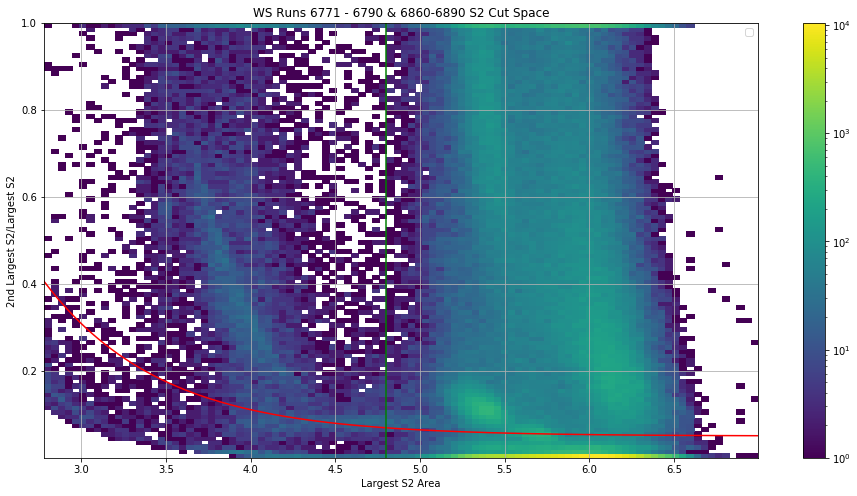

In [11]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.hist2d(np.log10(S2max), test,bins=100,cmin=1,norm=matplotlib.colors.LogNorm()) #facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=1)
#plt.scatter(cutS1,test2,marker = 'x',color = 'r',label = 'Cut')
plt.colorbar()
plt.plot(testspace,testcut2,'r-')
plt.axvline(x=4.8, color='g', linestyle='-')
#plt.plot(testspace,testcut3,'k-')
#n = n.astype('int')
#for i in range(len(patches)):
#    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))
#ax.set_yscale('log')
#ax.set_xscale('log')
#plt.ylim([0,100])
plt.title('') 
plt.ylabel('2nd Largest S2/Largest S2') 
plt.xlabel('Largest S2 Area')
ax.set_title('WS Runs 6771 - 6790 & 6860-6890 S2 Cut Space')
#ax.set_title('Skimmed DD S2 Cut Space')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
ratiocut = []
for i,(j,k) in enumerate(zip(np.log10(S2max),test)):
    if k > 20*np.exp(-1.45*j)+0.05:
    #if k > 0.4 and j < 4:
        #print(runIDS2[i], eventIDS2[i])
        #print(s1small[i],S1max[i])
        ratiocut.append(True)
        #if count < 50:
    else:
        ratiocut.append(False)

In [16]:
CutS2max = np.array(S2max)
CutS2yaxis = np.array(S2yaxis)
Cutrun = np.array(runIDS2)
Cutevent = np.array(eventIDS2)
Cuts1 = np.array(s1)
rcutS2max = list(CutS2max[ratiocut])
rcutS2yaxis = list(CutS2yaxis[ratiocut])
rcutrunID = list(Cutrun[ratiocut])
rcuteventID = list(Cutevent[ratiocut])
rcutS1 = list(Cuts1[ratiocut])

In [17]:
testspace = np.linspace(2,5,1000)
testspace2 = np.linspace(5,7,1000)
h2wcut = 0.3*testspace-4.7
h2wcut2 = 0.9*testspace2-6.9


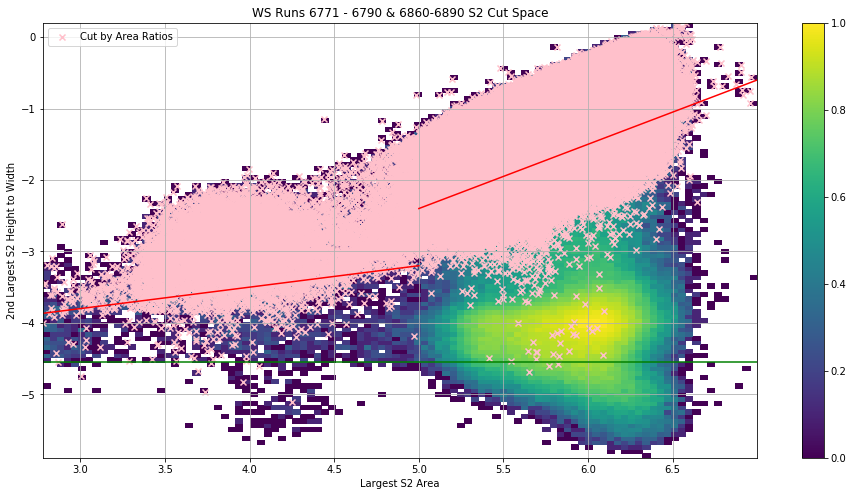

In [19]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.hist2d(np.log10(S2max), S2yaxis,bins=100,cmin=1,norm=matplotlib.colors.LogNorm()) #facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=1)
plt.scatter(np.log10(rcutS2max),rcutS2yaxis,marker = 'x',color = 'pink',label = 'Cut by Area Ratios')
plt.colorbar()
plt.plot(testspace,h2wcut,'r-')
plt.plot(testspace2,h2wcut2,'r-')
plt.axhline(y=-4.55, color='g', linestyle='-')
#plt.plot(testspace,testcut3,'k-')
#n = n.astype('int')
#for i in range(len(patches)):
#    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))
#ax.set_yscale('log')
#ax.set_xscale('log')
#plt.ylim([0,100])
plt.title('') 
plt.ylabel('2nd Largest S2 Height to Width') 
plt.xlabel('Largest S2 Area')
#ax.set_title('Skimmed DD S2 Cut Space')
ax.set_title('WS Runs 6771 - 6790 & 6860-6890 S2 Cut Space')
plt.grid(True)
plt.legend()
plt.show()

In [20]:
combocut = []
for i,(j,k) in enumerate(zip(np.log10(rcutS2max),rcutS2yaxis)):
    #if k > 10*np.exp(-0.27*j)+0.18 and k > 0.95:
    if k < -4:#k > 0.9*j-6.9: #k > 0.3*j-4.7:
        print(rcutrunID[i], rcuteventID[i])
        #print(S2max[i],S2yaxis[i])
        combocut.append(True)
        #if count < 50:
    else:
        combocut.append(False)

6771 22976
6771 128259
6771 6704
6771 120813
6772 26740
6772 10344
6772 34586
6772 4832
6772 49606
6772 112059
6772 9975
6773 20577
6773 15395
6773 68410
6773 41914
6773 52924
6773 22793
6773 91556
6773 99482
6774 134830
6774 33210
6774 46218
6774 16835
6775 31170
6775 34325
6775 102726
6775 19334
6775 80860
6775 14249
6775 132824
6775 53076
6775 70132
6775 84469
6776 63591
6776 146091
6776 56517
6776 102927
6776 31972
6776 136165
6777 865
6777 49971
6777 128842
6777 139176
6778 146324
6778 95555
6779 15177
6779 41524
6779 140799
6779 89280
6779 124592
6779 133001
6780 72434
6780 4948
6780 105933
6780 34825
6780 93
6780 114067
6780 136811
6780 41023
6780 19367
6781 97968
6781 90415
6781 59000
6781 146033
6782 130431
6782 131453
6782 15993
6782 43944
6782 118159
6783 133081
6783 99646
6783 127213
6784 65733
6784 89382
6784 74391
6784 75732
6784 86001
6785 125363
6785 46721
6785 58717
6785 11124
6785 103717
6785 52784
6785 54646
6785 51305
6785 77825
6785 124148
6785 128223
6786 14874
67

In [ ]:
thefile = "/global/cfs/cdirs/lz/data/reconstructed/SR1/LZAP-5.4.5_PROD-0/202112/lz_202112230937_006771/rq/lz_006771_000000_rq.root"
events = uproot.open(thefile)['Events']
scatters = uproot.open(thefile)['Scatters']
eventsPID = events.array('pulsesTPC.pulseID')
PA = events.array('pulsesTPC.pulseArea_phd')
PS = events.array('pulsesTPC.pulseStartTime_ns')/1000
S2prob = events.array('pulsesTPC.s2Probability')
S1prom = scatters.array('ms.s1PulseID')
PH = events.array('pulsesTPC.peakAmp')
a = events.array('pulsesTPC.areaFractionTime95_ns')
b = events.array('pulsesTPC.areaFractionTime5_ns')
runID = events.array('eventHeader.runID')
eventID = events.array('eventHeader.eventID')
nMS = scatters.array('ms.nSingleScatters')

PW = a - b

isMS = nMS == 1

PASS = PA[isMS]
PWSS = PW[isMS]
PHSS = PH[isMS]
PSSS = PS[isMS]
S2prob = S2prob[isMS]
S1prom = S1prom[isMS]
runID = runID[isMS]
eventID = eventID[isMS]
print("1")

isS2 = S2prob > 0 #assign a boolean true for a value with a S1 to make a mask for S1s
PAS2 = PASS[isS2] # grab pulse areas for S1s
PWS2 = PWSS[isS2]
PHS2 = PHSS[isS2]
PSS2 = PSSS[isS2]
print("2")
PSS1 = [] #rgab the S1 start time 
PAS1 = [] 

for i,j in zip(PSSS,S1prom):
    PSS1.append(i[j])

for i,j in zip(PASS,S1prom):
    PAS1.append(i[j])

PAS1 = np.array(PAS1)
PSS1 = np.array(PSS1)

morethan1_S2 = PAS2.count() > 1 #make a mask that makes sure there are multple S1s in an event

PA_MultiS2 = PAS2[morethan1_S2] #get the relevant areas, width, and heights
PW_MultiS2 = PWS2[morethan1_S2]
PH_MultiS2 = PHS2[morethan1_S2] # Only have events with more than 1 s1 now
PSS1 = PSS1[morethan1_S2]
PAS1 = PAS1[morethan1_S2]
PSS2 = PSS2[morethan1_S2]
runIDS2 = runID[morethan1_S2]
eventIDS2 = eventID[morethan1_S2]   

print("3")
PAmaxS2 = PA_MultiS2.max()  #find the max area in each event

s2max = PAmaxS2 < 1e7
s2min = PAmaxS2 > 600
lowE = np.logical_and(s2max,s2min)

"""DTcut = []
for i in FIDZ_ID:
    if any(i):
        DTcut.append(True)
    else:
        (DTcut.append(False))"""


PA_lowE = PA_MultiS2[lowE] #get the relevant areas, width, and heights
PW_lowE = PW_MultiS2[lowE]
PH_lowE = PH_MultiS2[lowE] # Only have events with more than 1 s1 now
runIDlowE = runIDS2[lowE]
eventIDlowE = eventIDS2[lowE] 
PAS1 = PAS1[lowE]
PSS2 = PSS2[lowE]
PSS1 = PSS1[lowE]

S2smalllow = PA_lowE.argsort() == 1 #mask to find the 2nd largest S1 in an event
S2biglow = PA_lowE.argsort() == 0

PSsmall = PSS2[S2smalllow]
PSbig = PSS2[S2biglow]

print("4")
time_ID = PSsmall > PSS1 #we want to make sure that the largest and 2nd largest are before the S2
#    time_ID = np.logical_and(smalltime,bigtime)
time_ID = list(itertools.chain.from_iterable(time_ID))

PA_time = PA_lowE[time_ID] #get the relevant areas, width, and heights
PW_time = PW_lowE[time_ID]
PH_time = PH_lowE[time_ID] # Only have events with more than 1 s1 now
runIDtime = runIDlowE[time_ID]
eventIDtime = eventIDlowE[time_ID] 
PAS1 = PAS1[time_ID]
PSS2 = PSS2[time_ID]
PSS1 = PSS1[time_ID]

PAmaxS2 = PA_time.max()  #find the max area in each event

S2small = PA_time.argsort() == 1    
S2big = PA_time.argsort() == 0
PAsmallS2 = PA_time[S2small] #2nd largest area
PHsmallS2 = PH_time[S2small] #2nd largest height
PWsmallS2 = PW_time[S2small] #2nd largest width
PSsmall = PSS2[S2small]
PSbig = PSS2[S2big]

S2ratio = np.log10(PAsmallS2 / PAmaxS2) #calculate desired ratios to plot
S2_h2w_ratio = np.log10(PHsmallS2 / PWsmallS2)
print("5")

return S2ratio , S2_h2w_ratio , PAmaxS2,PAsmallS2,runIDtime,eventIDtime, PAS1

In [ ]:
eventID[0:10]

In [ ]:
PAS2[0:10]

In [ ]:
PASS[0:10]